## Notes for Varshini

1. Changed pre-processing because learning with MSE has these issues
 - Hard to train 
 - Need to sum across pixels and not take the mean
 
2. Changed the architecture bc.
 - KL divergence is low, but reconstruction error still very high
 
3. Changed input shape from $(28,28)$ to $(28,28,1)$ because using conv layers

In [1]:
import numpy as np
import pandas as p
import tensorflow as tf

import matplotlib.pyplot as plt

from tensorflow.keras.datasets import mnist
from tensorflow.keras import layers, models, optimizers, regularizers


In [135]:
# GET THE MNIST DATA
(x_train, _), (x_test, _) = mnist.load_data()


In [167]:
# Function to 
# 1. Change dimensions
# 2. Change datatype
def binary_preprocess(imageset):
    imageset = imageset.reshape(imageset.shape[0],28,28,1)/255.
    return np.where(imageset > .5, 1.0,0.0).astype('float32')

In [168]:
# Pre-processed images 
x_train_images = binary_preprocess(x_train)
x_test_images = binary_preprocess(x_test)

In [216]:
# Dataset object to get a mini-batch
batch_size = 32
train_size = x_train_images.shape[0]
train_dataset = (tf.data.Dataset.from_tensor_slices(x_train_images)
                 .shuffle(train_size).batch(batch_size))

In [173]:
def get_encoder():
  # THE ENCODER DEFINITION
    encoded = tf.keras.models.Sequential(
          [
            tf.keras.layers.InputLayer(input_shape=(28, 28, 1)),
            tf.keras.layers.Conv2D(
                filters=32, kernel_size=3, strides=(2, 2), activation='relu'),
            tf.keras.layers.Conv2D(
                filters=64, kernel_size=3, strides=(2, 2), activation='relu'),
            tf.keras.layers.Flatten(),
            # No activation
            tf.keras.layers.Dense(4),
        ]
    )
    return encoded


def get_decoder():
    decoded = tf.keras.Sequential(
        [
            tf.keras.layers.InputLayer(input_shape=(2,)),
            tf.keras.layers.Dense(units=7*7*32, activation=tf.nn.relu),
            tf.keras.layers.Reshape(target_shape=(7, 7, 32)),
            tf.keras.layers.Conv2DTranspose(
                filters=64, kernel_size=3, strides=2, padding='same',
                activation='relu'),
            tf.keras.layers.Conv2DTranspose(
                filters=32, kernel_size=3, strides=2, padding='same',
                activation='relu'),
            # No activation
            tf.keras.layers.Conv2DTranspose(
                filters=1, kernel_size=3, strides=1, padding='same'),
        ]
    )

    return decoded


## Terminology 

- mean is $\mu$
- variance is $\sigma^2$
- std deviation is $\sigma$
- $\log{\sigma}$ = $\frac{1}{2}{log{\sigma^2}}$
- $\sigma$ = $\exp({\frac{1}{2}{log{\sigma^2}}})$
- - $\log{\sigma^2}$ = $2{log{\sigma}}$


In [211]:
# Encoding step
# Get the mean and the variance
def encode(encoder,x):
    activations = encoder(x)
    mean, variance = tf.split(activations,num_or_size_splits=2,axis=1)
    return mean,variance

# Reparametrization step
def sample(mu, logvar):
    e = tf.random.normal(shape=mu.shape)
    return e * tf.exp(logvar/2) + mu

# Combine the autoencoder
def autoencoder(encoder,decoder,x):
    mean,logvariance = encode(encoder,x)
    z = sample(mean,logvariance)
    output = decoder(z)
    return output

## Be careful

1. What is `sample` above?

2. What is the PDF of a normal distribution?

$$
f(x)=\frac{1}{\sigma \sqrt{2 \pi}} e^{-\frac{1}{2}\left(\frac{x-\mu}{\sigma}\right)^{2}}
$$

3. Mean squared error is not the right approach. Because we assume each is normally distributed

In [261]:
mean, variance = encode(harencoder,x_train_images)

<tf.Tensor: shape=(60000, 2), dtype=float32, numpy=
array([[ 0.2548442 ,  0.07210281],
       [ 1.7183516 , -1.2550998 ],
       [ 0.02361488,  0.9139986 ],
       ...,
       [-1.3921298 ,  1.1864004 ],
       [ 1.8548329 ,  1.2522751 ],
       [-0.3437529 , -0.62872946]], dtype=float32)>

In [213]:
# Quick way to get the log likelihood of a normal distribution
def log_normal_pdf(value, mean, logvar, raxis=1):
    log_2pi = tf.math.log(2. * np.pi)
    logpdf = -(logvar + log_2pi + (value - mean)**2. * tf.exp(-logvar))/2
    return tf.reduce_sum(logpdf,axis=1)

# Loss over the assumed distribution(qz_x) and the prior(pz)
def kl_loss(encoder, x):
    mean, logvar = encode(encoder,x)
    z = sample(mean,logvar)
    logpz = log_normal_pdf(z, 0., 0.)
    logqz_x = log_normal_pdf(z, mean, logvar)
    return tf.reduce_mean(logqz_x - logpz)

# This is now binary cross entropy
# Crucially, observe that we sum across the image dimensions
# and only take the mean in the images dimension
def reconstruction_loss(encoder,decoder,x):
    x_logits = autoencoder(encoder,decoder,x)
    loss = tf.nn.sigmoid_cross_entropy_with_logits(logits=x_logits,labels=x)
    return tf.reduce_mean(tf.reduce_sum(loss,axis=[1,2,3]))

In [ ]:
# Define the loss function

# Instantiate an optimizerc
optimizer = tf.keras.optimizers.Adam(learning_rate=1e-3)

# Define number of epochs
num_epochs = 10
harencoder = get_encoder()
hardecoder = get_decoder()

train_size = x_train_images.shape[0]
batch_size = 32

# Loop over the required number of epochs
for i in range(num_epochs):
    for i in range(int(train_size/batch_size)):
        
        x_train_batch = x_train_images[np.random.choice(train_size,batch_size)]
        

        with tf.GradientTape(persistent=True) as t:

            decoder_output = autoencoder(harencoder,hardecoder,x_train_batch)

            L1 = reconstruction_loss(encoder,decoder,x_train_batch)
            L2 = kl_loss(encoder,x_train_batch)
            loss = L1 + L2
        gradients1 = t.gradient(loss, decoder.trainable_weights)
        gradients2 = t.gradient(loss, encoder.trainable_weights)

        optimizer.apply_gradients(zip(gradients1, decoder.trainable_weights))
        optimizer.apply_gradients(zip(gradients2, encoder.trainable_weights))

          
    print(f'Loss at epoch {i} is {loss:.2f}, KL Divergence is {L2:.2f}')


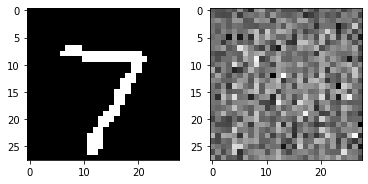

In [258]:
# Verify if there is some learning
fig, ax = plt.subplots(1,2)

# Prediction 
pred = tf.sigmoid(autoencoder(harencoder,hardecoder,x_test_images[0:1]))
pred = pred.numpy().squeeze()

ax[0].imshow(x_test_images[0].squeeze(),cmap='gray')
ax[1].imshow(pred,cmap='gray')